# Proyecto T6

In [1]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')



Estamos usando: cpu


## Supernova parametric model (SPM)

Existen 4 tipos de supernovas: SNIbc, SNIa, SNII, SLSN

In [3]:
def SPM(t, A, t_0, t_1, B, t_rise, t_fall):
    gamma = (t_1 - t_0)
    s = 0.2
    F = []
    
    for t_i in t:
        # g(t)
        arg = s*(t_i-(gamma+t_0))
        g = 1/(1 + np.exp(- arg))
        
        # F_early and F_late
        x_early = A*(1-B*((t_i-t_0)/gamma))
        x_late = (A*(1-B)*np.exp(gamma/t_fall))
        y = (1+np.exp(-(t_i-t_0)/t_rise))
        
        F_early = x_early/y
        F_late = x_late/y
        
        #F_sne
        F_i = F_early*(1-g) + F_late*g
        F.append(F_i)
        
    return torch.FloatTensor(F)

In [4]:
# parameters

#Amplitud: cerca de 20
#t0: timpo inicial
#t_1: tiempo en que empieza a transisionar la SN
#gamma: controls the time duration of the SN-plateau region
#beta: controls the slope of the SN-plateau region (pendiente)
#t_rise: controls the required time to reach the maximum brightness along the light-curve
#t_fall: controls the brightness decay time along and after the SN-plateau region

A = 10
t_0 = 58600
t_1 = 58640
B = 0.8
t_rise = 20
t_fall = 50


100


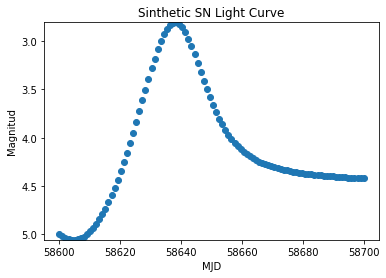

In [5]:
t = np.linspace(58600,58700,100)
F = SPM(t, A, t_0, t_1, B, t_rise, t_fall)
print(len(F))

plt.plot(t, F, 'o')
plt.title("Sinthetic SN Light Curve")
plt.xlabel("MJD")
plt.ylabel("Magnitud")
plt.ylim(max(F),min(F))
plt.show()

In [6]:
import random
x = np.random.normal(loc=0.0, scale=1.0, size=None)
x


-1.4002081516511913

In [7]:
As = np.random.randint(20, 50, 100)
#t_0 = np.random.randint(58500, 58600, 100)
#t_1 = np.random.randint(58600, 58700, 100)
Bs = np.random.rand(100)
#t_rise = np.random.randint(20, 30, 100)
#t_fall = np.random.randint(40, 60, 100)
    


## Dataset

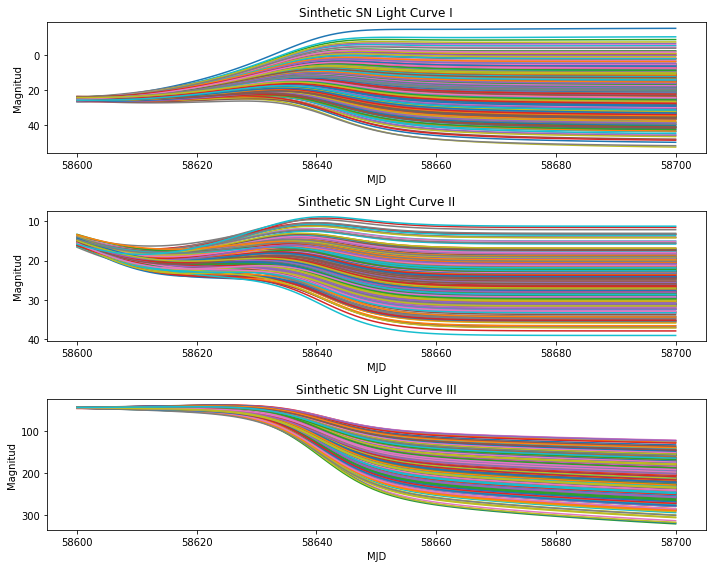

In [8]:
LC_1 = []
LC_2 = []
LC_3 = []

t = np.linspace(58600,58700,100)
fig, ax = plt.subplots(3, 1, figsize=(10,8))



for i in range(500):
    A_1 = np.random.normal(loc=50, scale=1.0, size=None)
    B_1 = np.random.normal(loc=0.8, scale=0.1, size=None)
    t_rise_1 = np.random.normal(loc=25, scale=1.0, size=None)
    t_fall_1 = np.random.normal(loc=50, scale=2.0, size=None)
    LC_1.append(SPM(t, A_1, t_0, t_1, B_1, t_rise_1, t_fall_1))
    
    
    
    A_2 = np.random.normal(loc=30, scale=1.0, size=None)
    B_2 = np.random.normal(loc=0.5, scale=0.1, size=None)
    t_rise_2 = np.random.normal(loc=10, scale=1.0, size=None)
    t_fall_2 = np.random.normal(loc=80, scale=2.0, size=None)
    LC_2.append(SPM(t, A_2, t_0, t_1, B_2, t_rise_2, t_fall_2))
    
    
    A_3 = np.random.normal(loc=90, scale=1.0, size=None)
    B_3 = np.random.normal(loc=0.3, scale=0.1, size=None)
    t_rise_3 = np.random.normal(loc=50, scale=1.0, size=None)
    t_fall_3 = np.random.normal(loc=30, scale=2.0, size=None)
    LC_3.append(SPM(t, A_3, t_0, t_1, B_3, t_rise_3, t_fall_3))

    ax[0].plot(t, LC_1[i])
    ax[1].plot(t, LC_2[i])
    ax[2].plot(t, LC_3[i])

ax[0].set_title("Sinthetic SN Light Curve I")
ax[0].set_xlabel("MJD")
ax[0].set_ylabel("Magnitud")

ax[1].set_title("Sinthetic SN Light Curve II")
ax[1].set_xlabel("MJD")
ax[1].set_ylabel("Magnitud")

ax[2].set_title("Sinthetic SN Light Curve III")
ax[2].set_xlabel("MJD")
ax[2].set_ylabel("Magnitud")

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

fig.tight_layout()
plt.show()

In [9]:
tensor_LC_1 = torch.stack(LC_1)
print('Shape LC_1: ',tensor_LC_1.shape)

labels_LC_1 = torch.zeros(500)
print('Shape Labels LC_1: ',labels_LC_1.shape)

tensor_LC_2 = torch.stack(LC_2)
print('Shape LC_2: ',tensor_LC_2.shape)

labels_LC_2 = torch.ones(500)
print('Shape Labels LC_2: ',labels_LC_2.shape)

tensor_LC_3 = torch.stack(LC_3)
print('Shape LC_3: ',tensor_LC_3.shape)

labels_LC_3 = 2*torch.ones(500)
print('Shape Labels LC_3: ',labels_LC_3.shape)


Shape LC_1:  torch.Size([500, 100])
Shape Labels LC_1:  torch.Size([500])
Shape LC_2:  torch.Size([500, 100])
Shape Labels LC_2:  torch.Size([500])
Shape LC_3:  torch.Size([500, 100])
Shape Labels LC_3:  torch.Size([500])


In [10]:
x_train_tensor = torch.cat((tensor_LC_1, tensor_LC_2, tensor_LC_3))
y_train_tensor = torch.cat((labels_LC_1, labels_LC_2, labels_LC_3))


#Shuffle the data
indices = torch.randperm(x_train_tensor.size()[0])
x_train_tensor=x_train_tensor[indices]
y_train_tensor=y_train_tensor[indices]

print(x_train_tensor.shape)
print(y_train_tensor.shape)


torch.Size([1500, 100])
torch.Size([1500])


## Custom Layer TimeFILM

In [11]:
class TimeFILM(nn.Module):
    def __init__(self, size_in, M): #size_in sería 128 o L x 128????
        super().__init__()
        self.size_in= size_in
        #self.t = t
        self.M = M
        self.T = torch.Tensor(size_in)
        a = torch.Tensor(M, size_in)
        b = torch.Tensor(M, size_in)
        v = torch.Tensor(M, size_in)
        w = torch.Tensor(M, size_in)
        self.a = nn.Parameter(a)  # nn.Parameter is a Tensor that's a module parameter.
        self.b = nn.Parameter(b)
        self.v = nn.Parameter(v)
        self.w = nn.Parameter(w)
     
        # initialize weights and biases
        torch.nn.init.normal_(self.a, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.b, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.v, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.w, mean=0.0, std=1.0)
        
        
    def forward(self, x):
        gamma = 0
        beta = 0
        for m in range(1,self.M+1):
            gamma = gamma + self.a[m-1]*torch.sin((2*np.pi*m)*self.T/(1.5*len(self.T))) + self.b[m-1]*torch.cos((2*np.pi*m)*self.T/(1.5*len(self.T)))
            beta = beta +   self.v[m-1]*torch.sin((2*np.pi*m)*self.T/(1.5*len(self.T))) + self.w[m-1]*torch.cos((2*np.pi*m)*self.T/(1.5*len(self.T)))
        
        out = gamma*x + beta
        x_out = torch.tanh(out)
        return x_out



## Positional encoding as in the paper

In [12]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=100, 
        d_model: int=128,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(1, max_seq_len, d_model)
        
        pe[ 0,:, 0::2] = torch.sin(position * div_term)
        
        pe[0, :, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [13]:
y =torch.ones([100,1,128])
y[:,0,1::2].shape

torch.Size([100, 64])

In [14]:
position = torch.arange(100).unsqueeze(1)
div_term = torch.exp(torch.arange(0, 128, 2) * (-math.log(10000.0) / 128))

x = position*div_term
print(x.shape)

pe = torch.zeros(100,1, 128)
print(pe.shape)

print(pe[:, 0, 0::2].shape)
print(pe[:, 0, 1::2].shape)

torch.Size([100, 64])
torch.Size([100, 1, 128])
torch.Size([100, 64])
torch.Size([100, 64])


## Serial Encoder

In [15]:
class SerialEncoder(nn.Module):
    def __init__(self, embed_size, M):
        super(SerialEncoder, self).__init__()
        self.M = M
        self.embed_size = embed_size # D = 128
        self.fc1 = nn.Linear(1, self.embed_size, bias=False)  
        self.TimeFILM = TimeFILM(self.embed_size, self.M)
        self.positional_encoding_layer = PositionalEncoder(d_model=embed_size, dropout=0.5, max_seq_len=100)                        
        self.fc2 = nn.Linear(self.embed_size, self.embed_size) 
        self.relu = nn.ReLU()
        self.MultiHeadAttention = nn.MultiheadAttention(self.embed_size, 4, batch_first=True)
        self.BN = nn.BatchNorm1d(128)
    
    def forward(self, x):    
        #x = x.view(x.size(0), -1)
        x = x[:, :, None] #[50, 100, 1]
        #print(x.shape)
        out = self.fc1(x) #[50, 100, 128]
        #print(out.shape)
        out = self.TimeFILM(out) #[50, 100, 128]
        #out = self.positional_encoding_layer(out)
        out = self.fc2(out) #[50, 100, 128]
        #print(out.shape)
        out = self.relu(out) #[50, 100, 128]
        #print(out.shape)
        out = 0.1*out
        out, attn_output_weights = self.MultiHeadAttention(out, out, out) #[50, 100, 128]
        #print(attn_output.shape)
        #print(attn_output[:,-1,:].shape)
        out = out[:,-1,:] #[50, 128]
        out = self.BN(out)
        return out, attn_output_weights

## Training

In [16]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [17]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores[0].max(dim=1) #pred shape (mb_size )
            #print('pred: ',pred)
            #print('label: ',yi)
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total   

In [18]:
def train(model, optimizer, x_train_tensor, y_train_tensor, mb_size, epochs=100):
    train_loss = []
    weights = []
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            scores = model(xi)

            yi = yi.type(torch.LongTensor)
            # funcion cost
            cost = torch.nn.functional.cross_entropy(input= scores[0], target=yi) #?????????????????????
            optimizer.zero_grad()
            cost.backward()
            
            optimizer.step()
            
        train_loss.append(cost.item())
        if epoch%10==0:    
            print(f'Epoch: {epoch}, loss: {cost.item()}, accuracy: {accuracy(model, x_train_tensor, y_train_tensor, mb_size)}')

    return train_loss
        

## Modelo

In [19]:
#Instanciar modelo
embed_size = 128 
M = 5
L = 100
lr = 0.01
epochs = 100
mb_size = 50

encoder = SerialEncoder(embed_size, M)

optimizer = torch.optim.SGD(encoder.parameters(), lr=lr)
loss = train(encoder, optimizer, x_train_tensor, y_train_tensor, mb_size, epochs)


Epoch: 0, loss: 3.789306879043579, accuracy: 0.8
Epoch: 10, loss: 1.903639793395996, accuracy: 0.86
Epoch: 20, loss: 1.3461554050445557, accuracy: 0.76
Epoch: 30, loss: 0.8717465996742249, accuracy: 0.84
Epoch: 40, loss: 0.5782080292701721, accuracy: 0.8
Epoch: 50, loss: 0.6863883137702942, accuracy: 0.88
Epoch: 60, loss: 0.5062845349311829, accuracy: 0.76
Epoch: 70, loss: 0.4764174222946167, accuracy: 0.84
Epoch: 80, loss: 0.4963819086551666, accuracy: 0.84
Epoch: 90, loss: 0.4715906083583832, accuracy: 0.84


In [20]:
#Instanciar modelo
embed_size = 128 
M = 10
L = 100
lr = 0.01
epochs = 100
mb_size = 50

encoder2 = SerialEncoder(embed_size, M)

optimizer = torch.optim.SGD(encoder.parameters(), lr=lr)
loss2 = train(encoder2, optimizer, x_train_tensor, y_train_tensor, mb_size, epochs)

Epoch: 0, loss: 5.049245834350586, accuracy: 0.0
Epoch: 10, loss: 5.026390552520752, accuracy: 0.0
Epoch: 20, loss: 4.967044830322266, accuracy: 0.0
Epoch: 30, loss: 5.0961174964904785, accuracy: 0.0
Epoch: 40, loss: 5.069587230682373, accuracy: 0.0
Epoch: 50, loss: 5.004871845245361, accuracy: 0.0
Epoch: 60, loss: 4.995965480804443, accuracy: 0.0
Epoch: 70, loss: 4.923618793487549, accuracy: 0.0
Epoch: 80, loss: 5.0052008628845215, accuracy: 0.0
Epoch: 90, loss: 5.0351409912109375, accuracy: 0.0


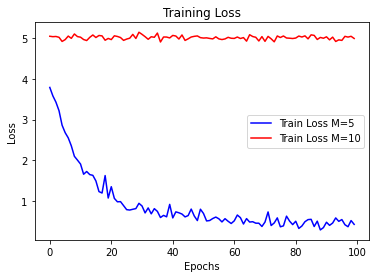

In [35]:
plt.figure()
plt.plot(loss, color='b', label='Train Loss M=5')
plt.plot(loss2, color='r', label='Train Loss M=10')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Attention Weights

In [22]:
attn_weight = encoder(x_train_tensor)[1]
print(attn_weight.shape)

torch.Size([1500, 100, 100])


In [23]:
attn_weight[60][10]

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], grad_fn=<SelectBackward>)

## Classifier

In [30]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X1 = encoder(x_train_tensor)[0].detach().numpy()
X2 = encoder2(x_train_tensor)[0].detach().numpy()
y = y_train_tensor.detach().numpy()

# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=66)

rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

rfc.fit(X_train,y_train)

# predictions
pred = rfc.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       158
         1.0       1.00      0.99      0.99       173
         2.0       1.00      1.00      1.00       164

    accuracy                           1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495



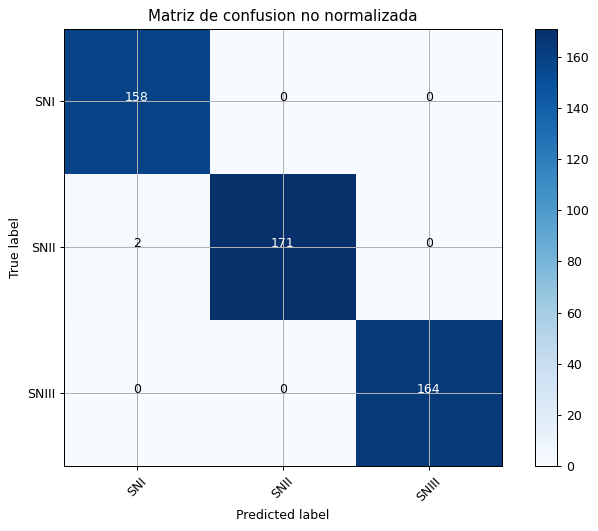

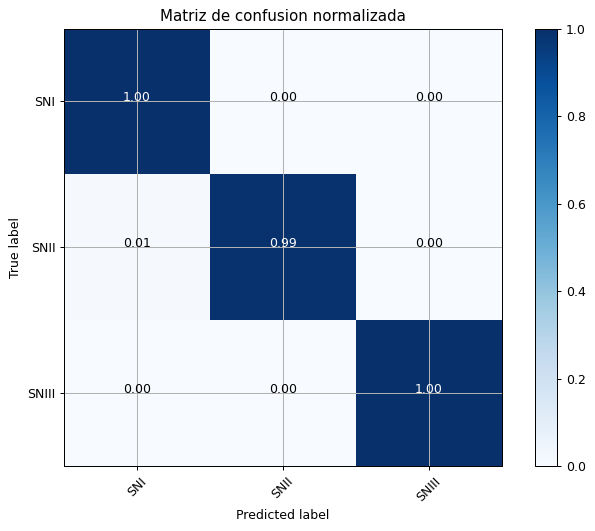

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

cm = confusion_matrix(y_test, pred)

def mean_recall(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal().mean()

def plot_confusion_matrix(cm, classes,
                          normalized=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Matriz de confusion normalizada'
        fmt = '.2f'
    else:
        title='Matriz de confusion no normalizada'
        fmt = 'd'
        
    plt.figure(figsize=(8, 6), dpi=90)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid('off')
    plt.tight_layout()
target_names = [
    'SNI',
    'SNII',
    'SNIII'
]
plot_confusion_matrix(cm, target_names, normalized=False)
plot_confusion_matrix(cm, target_names, normalized=True)




print(
    classification_report(
        y_true = y_test,
        y_pred = pred
    )
)


## PCA

In [32]:
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['y'] = y


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

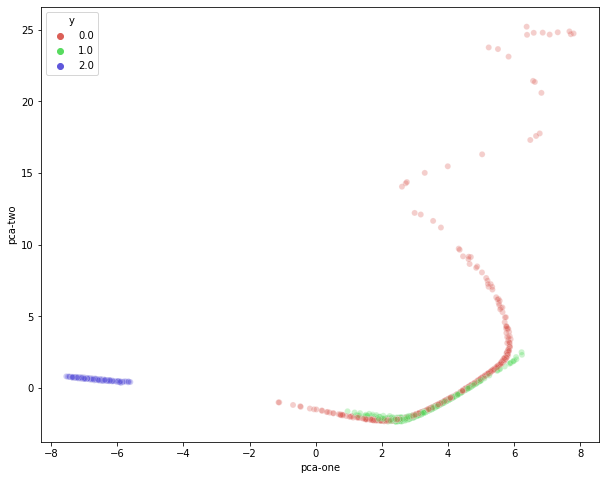

In [34]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.3
)

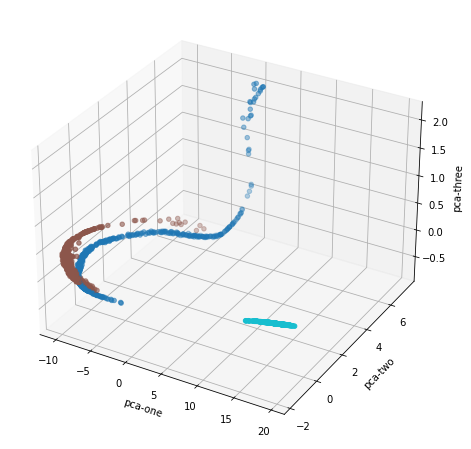

In [29]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()